<a href="https://colab.research.google.com/github/belzu/TFM-IA-UNIR-Students-Opinion-Mining-WebApp/blob/main/TFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

pip install pyspellchecker

pip install spacy

pip install spacy-stanza

pip install nltk

pip install scikit-plot

F12 + ESTO DE ABAJO (meter en console)
function KeepClicking(){
console.log("Clicking");
document.querySelector("colab-connect-button").click()
}
setInterval(KeepClicking,60000)


# SentimentEvaluator

## Modelo

In [ ]:
from pandas.io.spss import Path
import scikitplot as skplt
import pandas as pd
import numpy as np
import sklearn, re, glob
import matplotlib.pyplot as plt
import unicodedata
import nltk
from spellchecker import SpellChecker
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.ensemble import RandomForestClassifier
import collections, stanza, copy, pickle, json, joblib
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import TreebankWordTokenizer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator 
from sklearn.model_selection import StratifiedKFold
from joblib import dump, load
from datetime import datetime
from sklearn.metrics import accuracy_score
from sklearn import datasets, metrics, model_selection, svm

pd.set_option('display.max_colwidth', None)
pd.set_option("display.max_rows", None, "display.max_columns", None)
#Esta versión está pensada para sacar los datos del database.

class DataManager:
	
	synonyms = {
		  		"docente": r"(profesora?|educadora?|maestr(o|a)|pedagog(o|a)|instructora?|preceptora?)",
	            "malo": r"(mala|lamentable|horrible|decepci(onante|ón)|desorganizad(o|a)|incult(o|a)|penos(o|a)|p(é|e)sim(o|a)|deficiente|defectuos(o|a)|imperfect(o|a)|nefast(o|a)|desastr(e|os(o|a))|perjudicial|cruel|despiadad(o|a)|paup(é|e)rrim(o|a)|in(ú|u)til|inservible|incapaz|incompetente|inh(á|a)bil|inept(o|a))",				
				"bueno": r"(buena|maravillos(o|a)|organizad(o|a)|eficiente|virtuos(o|a)|genial|fant(á|a)stic(o|a)|correct(o|a)|magn(á|a)nim(o|a)|adecuad(o|a)|(í|i)ntegr(o|a)|(poco|nada|cero) mal(o|a)?)",
				"muy bueno": r"(poco|(para )?nada|en absoluto) malo",
				"muy malo": r"(poco|(para )?nada|en absoluto) bueno"
				}

	#Code obtained from https://micro.recursospython.com/recursos/como-quitar-tildes-de-una-cadena.html
	def remove_accents_in_word(word):
		replaced_vocals = (
			("á", "a"),
			("é", "e"),
			("í", "i"),
			("ó", "o"),
			("ú", "u"),
		)
		for accented, not_accented in replaced_vocals:
			word = word.replace(accented, not_accented).replace(accented.upper(), not_accented.upper())
		return word

	def read_comments_without_sentiments(path="/content/drive/MyDrive/TFM/Base de datos de CSVs"):
		comments = []
		#fields = ["Ciencias contables, Económicas y Administratívas", "Ciencias de la Salud", "Educación", "Humanidades y Ciencias Sociales", "Ingeniería"]
		fields = ["Ciencias contables, Económicas y Administratívas"]
		periods = ["2019-2", "2020-2", "2021-1", "2021-2"]
		for field in fields:
			for period in periods:
				for filename in glob.glob(f'{path}/{field}/{period}/evar19_labeled.csv'):
					print("Leyendo comentarios de " + filename)
					df = pd.read_csv(filename, delimiter='\t')
					comments.extend(df["Comentario"].values.tolist())
		return comments

	def read_comments_with_sentiments(path="/content/drive/MyDrive/TFM/Base de datos de CSVs"):
		comments = []
		sentiments = []
		fields = ["Ciencias contables, Económicas y Administratívas", "Ciencias de la Salud", "Educación", "Humanidades y Ciencias Sociales", "Ingeniería"]
		periods = ["2019-2", "2020-2", "2021-1", "2021-2"]
		for field in fields:
			for period in periods:
				for filename in glob.glob(f'{path}/{field}/{period}/evar19.csv'):
					print("Leyendo comentarios de " + filename)
					df = pd.read_csv(filename, delimiter='\t')
					comments.extend(df["Comentario"].values.tolist())
					sentiments.extend(df["Sentimiento"].values.tolist())
		comments = [[comments[i], int(sentiments[i])] for i in range(len(comments))]
		return comments

	def obtain_preprocessed_comments_with_sentiments(comments, correct=True, lemmatize=True, synonymize = False, snlp = stanza.Pipeline(lang="es")):
		#Se obtienen los comentarios preprocesados
		preprocessed_comments = DataManager.preprocess_comments([comment[0] for comment in comments], correct, lemmatize, synonymize, snlp)
		#Se obtienen los sentimientos de los comentarios
		sentiments = [comment[1] for comment in comments]
		#Se devuelven ambos
		return preprocessed_comments, sentiments

	def obtain_preprocessed_comments_without_sentiments(comments, correct=True, lemmatize=True, synonymize = False, snlp = stanza.Pipeline(lang="es")):
		#Se obtienen los comentarios preprocesados
		return DataManager.preprocess_comments(comments, correct, lemmatize, synonymize, snlp)

	'''
	Se realiza un pre-procesado de los comentarios que involucra corregir y lematizar palabras así como pasar todas las palabras a minuscula
	:param correct: True si se desea correccion de palabras, false si no
	:param lemmatize: True si se desea trabajar con los lemas de las palabras, false si no
	'''
	def preprocess_comments(comments, correct=True, lemmatize=True, synonymize = False, snlp = None):
		#Se pasan todos los comentarios a minuscula
		comments = [comment.lower() for comment in comments]
		#Se corrigen las palabras mal escritas, aunque hay que tener cuidado, pues puede proporcionar errores
		if correct:
			comments = DataManager.correct_mispelt_words(comments)
		#Se aplica la sinonimización
		if synonymize:
			DataManager.synonymize(comments)
		#Se aplica la lematizacion
		if lemmatize:
			comments = DataManager.lemmatize_words(comments, snlp)
		return comments

	def synonymize(comments):
		for idx,comment in enumerate(comments):
			for synonym in DataManager.synonyms:
				#print("Antes " + comments[idx])
				comments[idx] = re.sub(DataManager.synonyms[synonym], synonym, comments[idx])
				#print("Despues " + comments[idx])

	#Corrige todas las palabras que esten mal escritas (en este caso token es cada palabra o simbolo que compone un comentario)
	def correct_mispelt_words(comments, lang = 'es'):
		spell = SpellChecker(language=lang)
		for idx,comment in enumerate(comments):
			tokens = DataManager.get_all_tokens_in_comment(comment)
			misspelt = spell.unknown(tokens)
			if len(misspelt)>0:
				for token in misspelt:
					if token is not None and spell.correction(token) is not None:
						comments[idx] = re.sub(r"\b{}\b".format(re.escape(token)), spell.correction(token), comments[idx])
		return comments

	def get_all_tokens_in_comment(comment):
		tokenizer = RegexpTokenizer(r'\w+')
		return tokenizer.tokenize(comment)

	def lemmatize_words(comments, snlp):
		#Coge el vocabulario y sustituye cada palabra por su palabra lematizada
		for cidx, comment  in enumerate(comments):
			comment_tokens = snlp(comment)
			word_tokens = [token.text for sent in comment_tokens.sentences for token in sent.tokens]
			word_lemmas = [word.lemma for sent in comment_tokens.sentences for word in sent.words]
			text_and_lemmas = [(word.text, word.lemma) for sent in comment_tokens.sentences for word in sent.words]
			# TODO Se lematizan palabras en el conjunto de tokens que a StanzaLanguage se le hayan pasado por alto
			#Se lematizan todas las palabras de cada comentario (o documento)
			for text, lemma in text_and_lemmas:
				comments[cidx] = re.sub(r"\b{}\b".format(re.escape(str(text))), str(lemma).lower(), comments[cidx])
		return comments

	def save_comments(comments, sentiments, path = "./", filename = None):
		filename = DataManager.obtain_filename(filename)
		with open(path+filename+".dat", "wb") as outfile:
			# "wb" argument opens the file in binary mode
			pickle.dump((comments, sentiments), outfile)

	def load_comments(filename):
		with open(filename, "rb") as file:
			# "wb" argument opens the file in binary mode
			return pickle.load(file)	

	def obtain_filename(filename):
		if filename == None:
			return DataManager.get_current_date_time_str()
		else:
			return filename

	def get_current_date_time_str():
		now = datetime.now()
		dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
		dt_string = dt_string.replace("/","-")
		dt_string = dt_string.replace(" ","_")
		dt_string = dt_string.replace(":","_")
		return str(dt_string)


class SentimentManager:

	def __init__(self, data_representation_model = CountVectorizer(), data_classification_model = svm.SVC(), snlp = stanza.Pipeline(lang="es")):
		self.data_representation_model = data_representation_model
		#stop_words = [DataManager.remove_accents_in_word(i) for i in stopwords.words('spanish')]
		#stop_words.extend(stopwords.words('spanish'))
		#self.data_representation_model.stopwords = stop_words
		self.data_classification_model = data_classification_model
		self.snlp = snlp
	
	def train_with_comments_csv(self, ruta_csvs):
		self.train_with_comments(DataManager.read_comments_with_sentiments(ruta_csvs))

	def train_with_comments(self, comments, sentiments):
		count_array = self.transform_comments_into_count_array(comments)
		self.train(count_array, sentiments)
  
	#Convierte los comentarios a formato numerico
	def transform_comments_into_count_array(self, comments):
		count_matrix = self.data_representation_model.fit_transform(comments)
		count_array = count_matrix.toarray()
		return count_array

	#Entrena el modelo a partir del count_array de los comentarios (X_train) y de los sentimientos (y_train)
	def train(self, X_train, y_train):
		self.data_classification_model.fit(X_train, y_train)

	def predict_comments_and_save(self, comments, correct=True, lemmatize=True, synonymize = True, lang = "es", path = "./", filename=None):
		sentiments = self.predict_comments(comments, correct, lemmatize, synonymize, lang).tolist()
		result = [{"comment":i[0], "sentiment":i[1]} for i in zip(comments, sentiments)]
		stats = [sentiments.count(0), sentiments.count(1), sentiments.count(2)]
		result.append({"number_of_negatives": stats[0], "number_of_neutrals": stats[1],
		               "number_of_positives": stats[2] , "most_frequent": stats.index(max(stats))})
		filename = DataManager.obtain_filename(filename)
		with open(path+filename+".json", "w", encoding='utf-8') as outfile:
			json.dump(result, outfile)
   
	def predict_comments(self, comments, correct=True, lemmatize=True, synonymize = True, lang = "es"):
		preprocessed_comments = DataManager.obtain_preprocessed_comments_without_sentiments(comments, correct, lemmatize, synonymize, lang)
		return self.predict(self.data_representation_model.transform(preprocessed_comments).toarray())
  
	def predict(self, X):
		return self.data_classification_model.predict(X)
  
	def predict_proba(self, X):
		return self.data_classification_model.predict_proba(X)
  
	def get_accuracy(self, comments, correct = True, lemmatize = True, synonymize = False, lang="es", test_size = 0.3, random_state = None):
		preprocessed_comments, sentiments = DataManager.obtain__preprocessed_comments_with_sentiments(comments, correct, lemmatize, synonymize, lang)
		#Se obtiene el modelo de representacion de datos (el modelo que representa los comentarios de forma numerica)
		count_matrix = self.data_representation_model.fit_transform(preprocessed_comments)
		count_array = count_matrix.toarray()
		# El 30% de los datos será para testear, el 70% para entrenar
		X_train, X_test, y_train, y_test = train_test_split(count_array, sentiments, test_size=test_size, random_state=random_state) # 70% training and 30% test
		self.data_classification_model.fit(X_train, y_train)
		y_pred = self.data_classification_model.predict(X_test)
		acc = accuracy_score(y_test, y_pred)
		return y_pred, acc

	def load_model(filename):
		model = SentimentManager()
		model.data_representation_model, model.data_classification_model = joblib.load(filename)
		return model
	
	def save_model(self, path = "./", filename = None):
		if filename == None:
			filename = DataManager.get_current_date_time_str()
		with open(path+filename + ".joblib", 'wb') as fout:
			dump((self.data_representation_model, self.data_classification_model), fout)

	def k_folds_accuracys(self, X, cv = 5, scoring = 'f1_macro'):
		return cross_val_score(self.data_classification_model, X, sentiments, cv=cv, scoring = scoring)


INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: es (Spanish):
| Processor    | Package  |
---------------------------
| tokenize     | ancora   |
| mwt          | ancora   |
| pos          | ancora   |
| lemma        | ancora   |
| depparse     | ancora   |
| sentiment    | tass2020 |
| constituency | combined |
| ner          | conll02  |

INFO:stanza:Use device: gpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Loading: sentiment
INFO:stanza:Loading: constituency
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: es (Spanish):
| Processor    | Package  |
---------------------------
| tokenize     | ancora   |
| mwt          | ancora   |
| pos          | ancora   |
| lemma        | ancora   |
| depparse     | ancora   |
| sentiment    | tass2020 |
| constituency | combined |
| ner          | conll02  |

INFO:stanza:Use device: gpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Loading: sentiment
INFO:stanza:Loading: constituency
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: es (Spanish):
| Processor    | Package  |
---------------------------
| tokenize     | ancora   |
| mwt          | ancora   |
| pos          | ancora   |
| lemma        | ancora   |
| depparse     | ancora   |
| sentiment    | tass2020 |
| constituency | combined |
| ner          | conll02  |

INFO:stanza:Use device: gpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Loading: sentiment
INFO:stanza:Loading: constituency
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!


In [ ]:
commentarios = ["profesorados", "profesora", "profesores", "viajaron"]
print(DataManager.lemmatize_words(commentarios, stanza.Pipeline('es')))

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: es (Spanish):
| Processor    | Package  |
---------------------------
| tokenize     | ancora   |
| mwt          | ancora   |
| pos          | ancora   |
| lemma        | ancora   |
| depparse     | ancora   |
| sentiment    | tass2020 |
| constituency | combined |
| ner          | conll02  |

INFO:stanza:Use device: gpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Loading: sentiment
INFO:stanza:Loading: constituency
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!


['profesorado', 'profesora', 'profesor', 'viajar']


In [ ]:
#Inicialización del objeto donde se aloja la estructura "Bag of Words"
bag_of_words = CountVectorizer()
#Conjunto de comentarios (siendo cada comentario un documento)
comentarios = ["El perro pasea feliz por el bosque",
              "El perro ya no pasea feliz por el bosque"]
#Se transforman los comentarios a datos numéricos
count_matrix = bag_of_words.fit_transform(comentarios)
#Se imprime el diccionario que identifica mediante su índice correspondiente
#a cada palabra presente en el conjunto de comentarios
print(sorted(bag_of_words.vocabulary_.items()))
#Se imprime la matriz (m) donde se indica cuántas veces (m(i,j)) aparece cada
#palabra (j) en cada documento (i)
print(count_matrix)
#Se transforma la matriz en un array
count_array = count_matrix.toarray()
#Se imprime cada fila de la matriz, donde se indica cuántas veces está presente
#en cada comentario cada una de las palabras del conjunto de comentarios
for i,j in zip (comentarios, count_array):
    print(str(i) + " " + str(j))

[('bosque', 0), ('el', 1), ('feliz', 2), ('no', 3), ('pasea', 4), ('perro', 5), ('por', 6), ('ya', 7)]
  (0, 1)	2
  (0, 5)	1
  (0, 4)	1
  (0, 2)	1
  (0, 6)	1
  (0, 0)	1
  (1, 1)	2
  (1, 5)	1
  (1, 4)	1
  (1, 2)	1
  (1, 6)	1
  (1, 0)	1
  (1, 7)	1
  (1, 3)	1
El perro pasea feliz por el bosque [1 2 1 0 1 1 1 0]
El perro ya no pasea feliz por el bosque [1 2 1 1 1 1 1 1]


In [ ]:
#Inicialización del objeto donde se aloja la estructura "TF-IDF"
tf_idf = TfidfVectorizer()
#Conjunto de comentarios (siendo cada comentario un documento)
comentarios = ["El perro pasea feliz por el bosque",
              "El perro ya no pasea feliz por el bosque"]
#Se transforman los comentarios a datos numéricos
count_matrix = tf_idf.fit_transform(comentarios)
#Se imprime el diccionario que identifica mediante su índice correspondiente
#a cada palabra presente en el conjunto de comentarios
print(sorted(tf_idf.vocabulary_.items()))
#Se imprime la matriz (m) donde se indica la puntuación TF-IDF de cada
#palabra (j) en cada documento (i)
print(count_matrix)
#Se transforma la matriz en un array
count_array = count_matrix.toarray()
#Se imprime cada fila de la matriz, donde se indica la importancia de cada
#palabra en cada comentario
for i,j in zip (comentarios, count_array):
    print(str(i) + " " + str(j))

[('bosque', 0), ('el', 1), ('feliz', 2), ('no', 3), ('pasea', 4), ('perro', 5), ('por', 6), ('ya', 7)]
  (0, 0)	0.3333333333333333
  (0, 6)	0.3333333333333333
  (0, 2)	0.3333333333333333
  (0, 4)	0.3333333333333333
  (0, 5)	0.3333333333333333
  (0, 1)	0.6666666666666666
  (1, 3)	0.39054766417182263
  (1, 7)	0.39054766417182263
  (1, 0)	0.2778778796561673
  (1, 6)	0.2778778796561673
  (1, 2)	0.2778778796561673
  (1, 4)	0.2778778796561673
  (1, 5)	0.2778778796561673
  (1, 1)	0.5557557593123346
El perro pasea feliz por el bosque [0.33333333 0.66666667 0.33333333 0.         0.33333333 0.33333333
 0.33333333 0.        ]
El perro ya no pasea feliz por el bosque [0.27787788 0.55575576 0.27787788 0.39054766 0.27787788 0.27787788
 0.27787788 0.39054766]


## Lectura de datos

In [ ]:
ruta_csvs = "/content/drive/MyDrive/TFM/Base de datos de CSVs/"
ruta_modelos = "/content/drive/MyDrive/TFM/Modelos/"

In [ ]:
#nlp = stanza.Pipeline('es')
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#preprocessed_comments es una lista que guarda comentarios preprocesados
#sentiments es una lista que guarda los numeros que representan los sentimientos de dichos comentarios
preprocessed_comments, sentiments = DataManager.obtain_preprocessed_comments_with_sentiments(
                        DataManager.read_comments_with_sentiments(ruta_csvs), synonymize = False
)
DataManager.save_comments(preprocessed_comments, sentiments, path = ruta_csvs)

Leyendo comentarios de /content/drive/MyDrive/TFM/Base de datos de CSVs//Ciencias contables, Económicas y Administratívas/2019-2/evar19.csv
Leyendo comentarios de /content/drive/MyDrive/TFM/Base de datos de CSVs//Ciencias contables, Económicas y Administratívas/2020-2/evar19.csv
Leyendo comentarios de /content/drive/MyDrive/TFM/Base de datos de CSVs//Ciencias contables, Económicas y Administratívas/2021-1/evar19.csv
Leyendo comentarios de /content/drive/MyDrive/TFM/Base de datos de CSVs//Ciencias contables, Económicas y Administratívas/2021-2/evar19.csv
Leyendo comentarios de /content/drive/MyDrive/TFM/Base de datos de CSVs//Ciencias de la Salud/2019-2/evar19.csv
Leyendo comentarios de /content/drive/MyDrive/TFM/Base de datos de CSVs//Ciencias de la Salud/2020-2/evar19.csv
Leyendo comentarios de /content/drive/MyDrive/TFM/Base de datos de CSVs//Ciencias de la Salud/2021-1/evar19.csv
Leyendo comentarios de /content/drive/MyDrive/TFM/Base de datos de CSVs//Ciencias de la Salud/2021-2/eva

##Cargar comentarios

In [ ]:
import random
def remove_excessive_positives(preprocessed_comments, sentiments,
                               numb_delete_positives = 2000, numb_delete_neutral = 0):
    filtered_comments = []
    filtered_sentiments = []
    count_2 = 0
    count_1 = 0
    for i in zip(preprocessed_comments, sentiments):
        if i[1] == 2 and count_2 < numb_delete_positives:
            count_2 += 1
        elif i[1] == 1 and count_1 < numb_delete_neutral:
            count_1 += 1
        else:
            filtered_comments.append(i[0])
            filtered_sentiments.append(i[1])
    c = list(zip(filtered_comments, filtered_sentiments))
    random.shuffle(c)
    filtered_comments, filtered_sentiments = zip(*c)
    filtered_comments = list(filtered_comments)
    filtered_sentiments = list(filtered_sentiments)
    return filtered_comments, filtered_sentiments

In [ ]:
comentarios_extra = [["No es buen profesor", 0],
                     ["Es buen profesor", 2],
                     ["Es un buen profesor", 2],
                     ["Es un maestro bueno", 2],
                     ["Es un maestro horrible", 0],
                     ["Es un docente muy malo", 0],
                     ["No se le da bien", 0],
                     ["Se le da muy bien", 2],
                     ["Ninguna opinión", 1],
                     ["Es horrible", 0],
                     ["Fatal", 0]]
comentarios_extra_preprocess, sentiments_extra = DataManager.obtain_preprocessed_comments_with_sentiments(comentarios_extra)
comments_file = "preprocessed_comments_28-12-2022_19_20_38_with_sentiments.dat"
preprocessed_comments, sentiments = DataManager.load_comments(ruta_csvs+comments_file)
preprocessed_comments, sentiments = remove_excessive_positives(preprocessed_comments, sentiments)
preprocessed_comments.extend(comentarios_extra_preprocess)
sentiments.extend(sentiments_extra)

In [ ]:
print(sentiments.count(0))
print(sentiments.count(1))
print(sentiments.count(2))

2228
3222
3348


In [ ]:
for comentario, sentimiento in zip(preprocessed_comments, sentiments):
    print(comentario, sentimiento)

Se han truncado las últimas 5000 líneas del flujo de salida.
el profe deberir mejorar el orden al hacer el registro contable, ya que ser supremamente desordenado !!!!!!!!!! 0
excelente docente, uno profe mucho querido. 2
deber realizar el clase mas dedicar y en cuanto a el actividad que dejar ser mucho extenso  0
el profesor hacer tornar aburrido y poco interesante el clase, puesto que carecer de dinámica al enseñar, ser cierto de que el clase contener bastante teoría pero serio buen que implementar estrategia dinámico para el mejor enseñanza y aprendizaje de él enseñar 0
bien!
 2
observar y retroalimentar el práctica docente claramente constituir uno práctica de liderazgo en el clase el concepto pedagógico que hoy él demandar de el equipo directivo de el universidad mariano establecer metodología adecuado para el construcción de conocimiento. sin duda movilizar recurso para
mejorar el forma de enseñanza para el docente con impacto positivo en el aprendizaje de el
estudiante ser vital.

# Probar diferentes modelos

## SVC

### TFIDF

In [ ]:
repres_model_tfidf = TfidfVectorizer(ngram_range=(1,2)) #Tfidf
param_grid = {'C': [1, 10, 100],
              'kernel': ['linear']}
grid_classif_model = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3, scoring = "f1_macro")
sentim_model = SentimentManager(repres_model_tfidf, grid_classif_model)

In [ ]:
sentim_model.train_with_comments(preprocessed_comments, sentiments)
sentim_model.save_model(path=ruta_modelos, filename="BEST_F1_SVC_GRID_SEARCH_CV_TFIDF_V2")

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ................C=1, kernel=linear;, score=0.915 total time= 6.8min
[CV 2/5] END ................C=1, kernel=linear;, score=0.919 total time= 6.7min
[CV 3/5] END ................C=1, kernel=linear;, score=0.911 total time= 6.8min
[CV 4/5] END ................C=1, kernel=linear;, score=0.912 total time= 6.8min
[CV 5/5] END ................C=1, kernel=linear;, score=0.911 total time= 6.8min
[CV 1/5] END ...............C=10, kernel=linear;, score=0.908 total time= 8.0min
[CV 2/5] END ...............C=10, kernel=linear;, score=0.917 total time= 8.1min
[CV 3/5] END ...............C=10, kernel=linear;, score=0.913 total time= 7.9min
[CV 4/5] END ...............C=10, kernel=linear;, score=0.909 total time= 7.1min
[CV 5/5] END ...............C=10, kernel=linear;, score=0.907 total time= 7.0min
[CV 1/5] END ..............C=100, kernel=linear;, score=0.902 total time= 6.9min
[CV 2/5] END ..............C=100, kernel=linear;,

### Bag of words

In [ ]:
repres_model_bag_of_words = CountVectorizer(ngram_range=(1,2))
param_grid = {'C': [1, 10, 100],
              'kernel': ['linear']}
grid_classif_model = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3, scoring = "f1_macro")
sentim_model = SentimentManager(repres_model_bag_of_words, grid_classif_model)

In [ ]:
sentim_model.train_with_comments(preprocessed_comments, sentiments)
sentim_model.save_model(path=ruta_modelos, filename="BEST_F1_SVC_GRID_SEARCH_CV_Bag_of_Words_V2")

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ................C=1, kernel=linear;, score=0.884 total time= 4.9min
[CV 2/5] END ................C=1, kernel=linear;, score=0.888 total time= 4.8min
[CV 3/5] END ................C=1, kernel=linear;, score=0.883 total time= 4.8min
[CV 4/5] END ................C=1, kernel=linear;, score=0.887 total time= 4.8min
[CV 5/5] END ................C=1, kernel=linear;, score=0.884 total time= 4.7min
[CV 1/5] END ...............C=10, kernel=linear;, score=0.873 total time= 4.6min
[CV 2/5] END ...............C=10, kernel=linear;, score=0.879 total time= 4.5min
[CV 3/5] END ...............C=10, kernel=linear;, score=0.870 total time= 4.7min
[CV 4/5] END ...............C=10, kernel=linear;, score=0.880 total time= 4.4min
[CV 5/5] END ...............C=10, kernel=linear;, score=0.870 total time= 4.5min
[CV 1/5] END ..............C=100, kernel=linear;, score=0.873 total time= 4.2min
[CV 2/5] END ..............C=100, kernel=linear;,

## Multinomial NB

### TFIDF

In [ ]:
repres_model_tfidf = TfidfVectorizer(ngram_range=(1,2)) #Tfidf
param_grid = {
    'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001),
    'fit_prior': [True, False],
} 
grid_classif_model = GridSearchCV(MultinomialNB(), param_grid, refit = True, verbose = 3)
sentim_model = SentimentManager(repres_model_tfidf, grid_classif_model)

In [ ]:
sentim_model.train_with_comments(preprocessed_comments, sentiments)
sentim_model.save_model(path=ruta_modelos, filename="BEST_MULTINOMIAL_NB_GRID_SEARCH_CV_TFIDF_V2")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END ...........alpha=1, fit_prior=True;, score=0.907 total time=   1.4s
[CV 2/5] END ...........alpha=1, fit_prior=True;, score=0.910 total time=   1.3s
[CV 3/5] END ...........alpha=1, fit_prior=True;, score=0.910 total time=   1.2s
[CV 4/5] END ...........alpha=1, fit_prior=True;, score=0.915 total time=   1.5s
[CV 5/5] END ...........alpha=1, fit_prior=True;, score=0.906 total time=   1.2s
[CV 1/5] END ..........alpha=1, fit_prior=False;, score=0.911 total time=   1.4s
[CV 2/5] END ..........alpha=1, fit_prior=False;, score=0.911 total time=   1.3s
[CV 3/5] END ..........alpha=1, fit_prior=False;, score=0.914 total time=   1.4s
[CV 4/5] END ..........alpha=1, fit_prior=False;, score=0.916 total time=   1.6s
[CV 5/5] END ..........alpha=1, fit_prior=False;, score=0.906 total time=   1.3s
[CV 1/5] END .........alpha=0.1, fit_prior=True;, score=0.916 total time=   1.2s
[CV 2/5] END .........alpha=0.1, fit_prior=True;

In [ ]:
repres_model_tfidf = TfidfVectorizer(ngram_range=(1,2)) #Tfidf
param_grid = {
    'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001),
    'fit_prior': [True, False],
} 
grid_classif_model = GridSearchCV(MultinomialNB(), param_grid, refit = True, verbose = 3, scoring = "f1_macro")
sentim_model = SentimentManager(repres_model_tfidf, grid_classif_model)

In [ ]:
sentim_model.train_with_comments(preprocessed_comments, sentiments)
sentim_model.save_model(path=ruta_modelos, filename="BEST_F1_MULTINOMIAL_NB_GRID_SEARCH_CV_TFIDF_V2")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END ...........alpha=1, fit_prior=True;, score=0.903 total time=   1.2s
[CV 2/5] END ...........alpha=1, fit_prior=True;, score=0.906 total time=   1.2s
[CV 3/5] END ...........alpha=1, fit_prior=True;, score=0.906 total time=   1.2s
[CV 4/5] END ...........alpha=1, fit_prior=True;, score=0.911 total time=   1.2s
[CV 5/5] END ...........alpha=1, fit_prior=True;, score=0.901 total time=   1.2s
[CV 1/5] END ..........alpha=1, fit_prior=False;, score=0.908 total time=   1.2s
[CV 2/5] END ..........alpha=1, fit_prior=False;, score=0.908 total time=   1.2s
[CV 3/5] END ..........alpha=1, fit_prior=False;, score=0.910 total time=   1.2s
[CV 4/5] END ..........alpha=1, fit_prior=False;, score=0.912 total time=   1.2s
[CV 5/5] END ..........alpha=1, fit_prior=False;, score=0.902 total time=   1.2s
[CV 1/5] END .........alpha=0.1, fit_prior=True;, score=0.913 total time=   1.3s
[CV 2/5] END .........alpha=0.1, fit_prior=True;

### Bag of words

In [ ]:
repres_model_bag_of_words = CountVectorizer(ngram_range=(1,2)) #Bag of words
param_grid = {
    'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001),
    'fit_prior': [True, False],
} 
grid_classif_model = GridSearchCV(MultinomialNB(), param_grid, refit = True, verbose = 3)
sentim_model = SentimentManager(repres_model_bag_of_words, grid_classif_model)

In [ ]:
sentim_model.train_with_comments(preprocessed_comments, sentiments)
sentim_model.save_model(path=ruta_modelos, filename="BEST_MULTINOMIAL_NB_GRID_SEARCH_CV_Bag_of_Words_V2")

In [ ]:
repres_model_bag_of_words = CountVectorizer(ngram_range=(1,2)) #Bag of words
param_grid = {
    'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001),
    'fit_prior': [True, False],
} 
grid_classif_model = GridSearchCV(MultinomialNB(), param_grid, refit = True, verbose = 3, scoring = "f1_macro")
sentim_model = SentimentManager(repres_model_bag_of_words, grid_classif_model)

In [ ]:
sentim_model.train_with_comments(preprocessed_comments, sentiments)
sentim_model.save_model(path=ruta_modelos, filename="BEST_F1_MULTINOMIAL_NB_GRID_SEARCH_CV_Bag_of_Words_V2")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END ...........alpha=1, fit_prior=True;, score=0.907 total time=   4.2s
[CV 2/5] END ...........alpha=1, fit_prior=True;, score=0.908 total time=   4.2s
[CV 3/5] END ...........alpha=1, fit_prior=True;, score=0.905 total time=   4.2s
[CV 4/5] END ...........alpha=1, fit_prior=True;, score=0.909 total time=   4.3s
[CV 5/5] END ...........alpha=1, fit_prior=True;, score=0.898 total time=   4.3s
[CV 1/5] END ..........alpha=1, fit_prior=False;, score=0.876 total time=   4.3s
[CV 2/5] END ..........alpha=1, fit_prior=False;, score=0.877 total time=   4.3s
[CV 3/5] END ..........alpha=1, fit_prior=False;, score=0.893 total time=   4.3s
[CV 4/5] END ..........alpha=1, fit_prior=False;, score=0.888 total time=   4.3s
[CV 5/5] END ..........alpha=1, fit_prior=False;, score=0.867 total time=   4.3s
[CV 1/5] END .........alpha=0.1, fit_prior=True;, score=0.878 total time=   4.2s
[CV 2/5] END .........alpha=0.1, fit_prior=True;

## Pasivo Agresivo

### TFIDF

In [ ]:
repres_model_tfidf = TfidfVectorizer(ngram_range=(1,2))
param_grid = {"warm_start": [True],
              'C' : [0.003, 0.01, 0.03, 0.1],
              'loss': ['hinge', 'squared_hinge']
             }
grid_classif_model = GridSearchCV(PassiveAggressiveClassifier(), param_grid, refit = True, verbose = 3)
sentim_model = SentimentManager(repres_model_tfidf, grid_classif_model)

In [ ]:
sentim_model.train_with_comments(preprocessed_comments, sentiments)
sentim_model.save_model(path=ruta_modelos, filename="BEST_PASSIVE_AGGRESIVE_GRID_SEARCH_CV_TFIDF_V2")

In [ ]:
repres_model_tfidf = TfidfVectorizer(ngram_range=(1,2))
param_grid = {"warm_start": [True],
              'C' : [0.003, 0.01, 0.03, 0.1],
              'loss': ['hinge', 'squared_hinge']
             }
grid_classif_model = GridSearchCV(PassiveAggressiveClassifier(), param_grid, refit = True, verbose = 3, scoring = "f1_macro")
sentim_model = SentimentManager(repres_model_tfidf, grid_classif_model)

In [ ]:
sentim_model.train_with_comments(preprocessed_comments, sentiments)
sentim_model.save_model(path=ruta_modelos, filename="BEST_F1_PASSIVE_AGGRESIVE_GRID_SEARCH_CV_TFIDF_V2")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END C=0.003, loss=hinge, warm_start=True;, score=0.896 total time= 2.6min
[CV 2/5] END C=0.003, loss=hinge, warm_start=True;, score=0.900 total time= 2.8min
[CV 3/5] END C=0.003, loss=hinge, warm_start=True;, score=0.909 total time= 2.7min
[CV 4/5] END C=0.003, loss=hinge, warm_start=True;, score=0.900 total time= 2.8min
[CV 5/5] END C=0.003, loss=hinge, warm_start=True;, score=0.912 total time= 2.7min
[CV 1/5] END C=0.003, loss=squared_hinge, warm_start=True;, score=0.912 total time= 4.5min
[CV 2/5] END C=0.003, loss=squared_hinge, warm_start=True;, score=0.909 total time= 4.4min
[CV 3/5] END C=0.003, loss=squared_hinge, warm_start=True;, score=0.921 total time= 4.5min
[CV 4/5] END C=0.003, loss=squared_hinge, warm_start=True;, score=0.913 total time= 4.0min
[CV 5/5] END C=0.003, loss=squared_hinge, warm_start=True;, score=0.921 total time= 4.2min
[CV 1/5] END C=0.01, loss=hinge, warm_start=True;, score=0.905 total t

### Bag of words

In [ ]:
repres_model_bag_of_words = CountVectorizer(ngram_range=(1,2))
param_grid = {"warm_start": [True],
              'C' : [0.003, 0.01, 0.03, 0.1],
              'loss': ['hinge', 'squared_hinge']
             }
grid_classif_model = GridSearchCV(PassiveAggressiveClassifier(), param_grid, refit = True, verbose = 3, scoring = "f1_macro")
sentim_model = SentimentManager(repres_model_bag_of_words, grid_classif_model)

In [ ]:
sentim_model.train_with_comments(preprocessed_comments, sentiments)
sentim_model.save_model(path=ruta_modelos, filename="BEST_F1_PASSIVE_AGGRESIVE_GRID_SEARCH_CV_Bag_of_Words_V2")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END C=0.003, loss=hinge, warm_start=True;, score=0.899 total time= 1.9min
[CV 2/5] END C=0.003, loss=hinge, warm_start=True;, score=0.893 total time= 2.0min
[CV 3/5] END C=0.003, loss=hinge, warm_start=True;, score=0.888 total time= 2.0min
[CV 4/5] END C=0.003, loss=hinge, warm_start=True;, score=0.898 total time= 2.0min
[CV 5/5] END C=0.003, loss=hinge, warm_start=True;, score=0.890 total time= 1.9min
[CV 1/5] END C=0.003, loss=squared_hinge, warm_start=True;, score=0.896 total time= 2.6min
[CV 2/5] END C=0.003, loss=squared_hinge, warm_start=True;, score=0.899 total time= 2.8min
[CV 3/5] END C=0.003, loss=squared_hinge, warm_start=True;, score=0.881 total time= 2.8min
[CV 4/5] END C=0.003, loss=squared_hinge, warm_start=True;, score=0.893 total time= 2.6min
[CV 5/5] END C=0.003, loss=squared_hinge, warm_start=True;, score=0.896 total time= 2.5min
[CV 1/5] END C=0.01, loss=hinge, warm_start=True;, score=0.895 total t

In [ ]:
repres_model_bag_of_words = CountVectorizer(ngram_range=(1,2))
param_grid = {"warm_start": [True],
              'C' : [0.003, 0.01, 0.03, 0.1],
              'loss': ['hinge', 'squared_hinge']
             }
grid_classif_model = GridSearchCV(PassiveAggressiveClassifier(), param_grid, refit = True, verbose = 3, scoring = "f1_macro")
sentim_model = SentimentManager(repres_model_bag_of_words, grid_classif_model)

In [ ]:
sentim_model.train_with_comments(preprocessed_comments, sentiments)
sentim_model.save_model(path=ruta_modelos, filename="BEST_F1_PASSIVE_AGGRESIVE_GRID_SEARCH_CV_Bag_of_Words_V2")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END C=0.003, loss=hinge, warm_start=True;, score=0.866 total time= 2.5min
[CV 2/5] END C=0.003, loss=hinge, warm_start=True;, score=0.910 total time= 2.6min
[CV 3/5] END C=0.003, loss=hinge, warm_start=True;, score=0.870 total time= 2.5min
[CV 4/5] END C=0.003, loss=hinge, warm_start=True;, score=0.876 total time= 2.5min
[CV 5/5] END C=0.003, loss=hinge, warm_start=True;, score=0.878 total time= 2.6min
[CV 1/5] END C=0.003, loss=squared_hinge, warm_start=True;, score=0.861 total time= 3.0min
[CV 2/5] END C=0.003, loss=squared_hinge, warm_start=True;, score=0.902 total time= 3.3min
[CV 3/5] END C=0.003, loss=squared_hinge, warm_start=True;, score=0.869 total time= 2.9min
[CV 4/5] END C=0.003, loss=squared_hinge, warm_start=True;, score=0.876 total time= 3.2min
[CV 5/5] END C=0.003, loss=squared_hinge, warm_start=True;, score=0.875 total time= 3.3min
[CV 1/5] END C=0.01, loss=hinge, warm_start=True;, score=0.861 total t

# Obtención del mejor modelo

## SVC

### TFIDF

In [ ]:
svc_model = SentimentManager.load_model("/content/drive/MyDrive/TFM/Modelos/BEST_F1_SVC_GRID_SEARCH_CV_TFIDF_V2.joblib")
print(" Resultados del Grid Search ")
print("\n El mejor resultado ha sido:\n",svc_model.data_classification_model.best_score_)
print("\n La mejor combinación de hiperparámetros ha sido:\n",svc_model.data_classification_model.best_params_)

 Resultados del Grid Search 

 El mejor resultado ha sido:
 0.9135564270262947

 La mejor combinación de hiperparámetros ha sido:
 {'C': 1, 'kernel': 'linear'}


### Bag of Words

In [ ]:
svc_model = SentimentManager.load_model("/content/drive/MyDrive/TFM/Modelos/BEST_F1_SVC_GRID_SEARCH_CV_Bag_of_Words_V2.joblib")
print(" Resultados del Grid Search ")
print("\n El mejor resultado ha sido:\n",svc_model.data_classification_model.best_score_)
print("\n La mejor combinación de hiperparámetros ha sido:\n",svc_model.data_classification_model.best_params_)

 Resultados del Grid Search 

 El mejor resultado ha sido:
 0.8852689955414693

 La mejor combinación de hiperparámetros ha sido:
 {'C': 1, 'kernel': 'linear'}


## MultinomialNB

###TFIDF

In [ ]:
multinomial_model = SentimentManager.load_model("/content/drive/MyDrive/TFM/Modelos/BEST_F1_MULTINOMIAL_NB_GRID_SEARCH_CV_TFIDF_V2.joblib")
print(" Resultados del Grid Search ")
print("\n El mejor resultado ha sido:\n",multinomial_model.data_classification_model.best_score_)
print("\n La mejor combinación de hiperparámetros ha sido:\n",multinomial_model.data_classification_model.best_params_)

 Resultados del Grid Search 

 El mejor resultado ha sido:
 0.9091794264104122

 La mejor combinación de hiperparámetros ha sido:
 {'alpha': 0.1, 'fit_prior': False}


###Bag of Words

In [ ]:
multinomial_model = SentimentManager.load_model("/content/drive/MyDrive/TFM/Modelos/BEST_F1_MULTINOMIAL_NB_GRID_SEARCH_CV_Bag_of_Words_V2.joblib")
print(" Resultados del Grid Search ")
print("\n El mejor resultado ha sido:\n",multinomial_model.data_classification_model.best_score_)
print("\n La mejor combinación de hiperparámetros ha sido:\n",multinomial_model.data_classification_model.best_params_)

 Resultados del Grid Search 

 El mejor resultado ha sido:
 0.9054261872921565

 La mejor combinación de hiperparámetros ha sido:
 {'alpha': 1, 'fit_prior': True}


## Passive Aggressive

###TFIDF

In [ ]:
passive_agressive_model = SentimentManager.load_model("/content/drive/MyDrive/TFM/Modelos/BEST_F1_PASSIVE_AGGRESIVE_GRID_SEARCH_CV_TFIDF_V2.joblib")
print(" Resultados del Grid Search ")
print("\n El mejor resultado ha sido:\n",passive_agressive_model.data_classification_model.best_score_)
print("\n La mejor combinación de hiperparámetros ha sido:\n",passive_agressive_model.data_classification_model.best_params_)

 Resultados del Grid Search 

 El mejor resultado ha sido:
 0.9187726222853744

 La mejor combinación de hiperparámetros ha sido:
 {'C': 0.03, 'loss': 'hinge', 'warm_start': True}


###Bag of Words

In [ ]:
passive_agressive_model = SentimentManager.load_model("/content/drive/MyDrive/TFM/Modelos/BEST_F1_PASSIVE_AGGRESIVE_GRID_SEARCH_CV_Bag_of_Words_V2.joblib")
print(" Resultados del Grid Search ")
print("\n El mejor resultado ha sido:\n",passive_agressive_model.data_classification_model.best_score_)
print("\n La mejor combinación de hiperparámetros ha sido:\n",passive_agressive_model.data_classification_model.best_params_)

 Resultados del Grid Search 

 El mejor resultado ha sido:
 0.8934868247306099

 La mejor combinación de hiperparámetros ha sido:
 {'C': 0.003, 'loss': 'hinge', 'warm_start': True}


# Cross validation con los mejores modelos

## SVC

###TFIDF

In [ ]:
svc_K_fold = SentimentManager(TfidfVectorizer(ngram_range=(1,2)),
                              svm.SVC(C = 1,
                              kernel = "linear"))
X = svc_K_fold.data_representation_model.fit_transform(preprocessed_comments).toarray()
cv = KFold(n_splits=5, random_state = None, shuffle = True)
print("Accuracies with " + str(cv))
scores = cross_val_score(svc_K_fold.data_classification_model, X, sentiments, cv=cv, scoring = "f1_macro")
print("%0.4f accuracy with a standard deviation of %0.4f" % (scores.mean(), scores.std()))

Accuracies with KFold(n_splits=5, random_state=None, shuffle=True)
0.9142 accuracy with a standard deviation of 0.0073


###Bag of words

In [ ]:
svc_K_fold = SentimentManager(CountVectorizer(ngram_range=(1,2)),
                              svm.SVC(C = 1,
                              kernel = "linear"))
X = svc_K_fold.data_representation_model.fit_transform(preprocessed_comments).toarray()
cv = KFold(n_splits=5, random_state = None, shuffle = True)
print("Accuracies with " + str(cv))
scores = cross_val_score(svc_K_fold.data_classification_model, X, sentiments, cv=cv, scoring = "f1_macro")
print("%0.4f accuracy with a standard deviation of %0.4f" % (scores.mean(), scores.std()))

Accuracies with KFold(n_splits=5, random_state=None, shuffle=True)
0.8854 accuracy with a standard deviation of 0.0044


## Multinomial NB

###TFIDF

In [ ]:
multinominalNB_K_fold = SentimentManager(TfidfVectorizer(ngram_range=(1,2)),
                              MultinomialNB(alpha = 0.1, fit_prior = False))
X = multinominalNB_K_fold.data_representation_model.fit_transform(preprocessed_comments).toarray()
cv = KFold(n_splits=5, random_state = None, shuffle = True)
print("Accuracies with " + str(cv))
scores = cross_val_score(multinominalNB_K_fold.data_classification_model, X, sentiments, cv=cv, scoring = "f1_macro")
print("%0.4f accuracy with a standard deviation of %0.4f" % (scores.mean(), scores.std()))

Accuracies with KFold(n_splits=5, random_state=None, shuffle=True)
0.9094 accuracy with a standard deviation of 0.0071


###Bag of words

In [ ]:
multinominalNB_K_fold = SentimentManager(CountVectorizer(ngram_range=(1,2)),
                              MultinomialNB(alpha = 1, fit_prior = True))
X = multinominalNB_K_fold.data_representation_model.fit_transform(preprocessed_comments).toarray()
cv = KFold(n_splits=5, random_state = None, shuffle = True)
print("Accuracies with " + str(cv))
scores = cross_val_score(multinominalNB_K_fold.data_classification_model, X, sentiments, cv=cv, scoring = "f1_macro")
print("%0.4f accuracy with a standard deviation of %0.4f" % (scores.mean(), scores.std()))

Accuracies with KFold(n_splits=5, random_state=None, shuffle=True)
0.9041 accuracy with a standard deviation of 0.0058


## Passive Aggressive

###TFIDF

In [ ]:
passive_agressive_K_fold = SentimentManager(TfidfVectorizer(ngram_range=(1,2)),
                                            PassiveAggressiveClassifier(C=0.03,
                                                loss="hinge", warm_start = True))
cv = KFold(n_splits=5, random_state = None, shuffle = True)
X = passive_agressive_K_fold.transform_comments_into_count_array(preprocessed_comments)
print("Accuracies with " + str(cv))
scores = cross_val_score(passive_agressive_K_fold.data_classification_model, X, sentiments, cv=cv, scoring = "f1_macro")
print("%0.4f accuracy with a standard deviation of %0.4f" % (scores.mean(), scores.std()))

Accuracies with KFold(n_splits=5, random_state=None, shuffle=True)
0.9159 accuracy with a standard deviation of 0.0037


In [ ]:
print(len(preprocessed_comments))
print(len(sentiments))

8798
8798


###Bag of words

In [ ]:
passive_agressive_K_fold = SentimentManager(CountVectorizer(ngram_range=(1,2)),
                                            PassiveAggressiveClassifier(C=0.003,
                                                loss="hinge", warm_start = True))
cv = KFold(n_splits=5, random_state = None, shuffle = True)
X = passive_agressive_K_fold.transform_comments_into_count_array(preprocessed_comments)
print("Accuracies with " + str(cv))
scores = cross_val_score(passive_agressive_K_fold.data_classification_model, X, sentiments, cv=cv, scoring = "f1_macro")
print("%0.4f accuracy with a standard deviation of %0.4f" % (scores.mean(), scores.std()))

Accuracies with KFold(n_splits=5, random_state=None, shuffle=True)
0.8938 accuracy with a standard deviation of 0.0058


# Comentarios a mano
Se prueba el código con comentarios escritos a mano

In [ ]:
handmade_comments = [
                "Es muy mal profesor",
               "Muy buen profesor",
               "Muy mal profesor",
               "Creo que es un docente excelente!",
               "Sin comentarios",
               "Nada que decir",
               "Es muy malo como profesor",
               "profesor poco eficiente",
               "Pierde mucho tiempo",
               "Poco eficaz",
               "Docente con pesima calidad",
               "Maestro pésimo",
               "Profesor lamentable",
               "Una experiencia muy mala",
               "Ha resultado ser una decepción",
               "El peor docente que he tenido jamás",
               "Me parece que da clases aburridas",
               "Un docente al que no le importan sus alumnos",
               "Un docente al que le importan sus alumnos",
               "Ser más cercano",
               "Es muy cercano",
               "Le recomiendo mejorar su carácter",
               "Sabe mucho, pero no está a la altura",
               "Sabe mucho, pero tiene que mejorar",
               "Nada que objetar",
               "El peor",
               "El docente mas malo que me ha tocado",
               "No quiero volver a tener clase con él",
               "Quiero volver a tener clase con él",
               "Ojalá volver a tener clase con él",
               "Ojalá no volver a tener clase con él",
               "Una joya de profesor",
               "Docente desorganizado",
               "No me gusto como dio las clases",
               "Tiene que mejorar",
               "Puede mejorar, pero es bueno",
               "es bueno",
               "Excelente profesor",
               "Gran docente!",
               "No me gusto como dio clase",
               "El peor docente",
               "El peor maestro",
               "El mejor docente",
               "El mejor maestro",
               "El peor docente, pero tiene mucho que mejorar",
               "El peor profesor, pero tiene mucho que mejorar",
               "El mejor docente, pero tiene mucho que mejorar",
               "El mejor profesor, pero tiene mucho que mejorar",
               "muchas gracias por todo profe!",
               "un profe muy impuntual!",
               "malo",
               "bueno",
               "poco bueno",
               "nada malo",
               "muy malo",
               "muy bueno",
               "espero no volver a verle",
               "espero volver a verle",
               "calidad baja",
               "baja calidad",
               "tiene muy baja calidad para enseñar",
               "cambiadlo",
               "cambienlo",
               "lo tienen que cambiar",
               "no lo cambieis",
               "no lo cambien",
               "mantenedlo",
               "mantenganlo"
               ]
best_model = SentimentManager.load_model("/content/drive/MyDrive/TFM/Modelos/BEST_F1_PASSIVE_AGGRESIVE_GRID_SEARCH_CV_TFIDF_V2.joblib")
best_model.predict_comments_and_save(handmade_comments)

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: es (Spanish):
| Processor    | Package  |
---------------------------
| tokenize     | ancora   |
| mwt          | ancora   |
| pos          | ancora   |
| lemma        | ancora   |
| depparse     | ancora   |
| sentiment    | tass2020 |
| constituency | combined |
| ner          | conll02  |

INFO:stanza:Use device: gpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Loading: sentiment
INFO:stanza:Loading: constituency
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!


('Es una profesora fantástica', 2)
('Es un mal profesor', 0)
('Profesor malo', 0)
('Docente malo', 0)
('No es bueno', 1)
('Es horrible como profesor', 0)
('Ninguna opinion', 0)
('Enseña muy bien', 2)
('Muy contenta con la enseñanza', 2)
('Debería tener más en cuenta la opinión de los alumnos', 0)
('El mejor maestro que he tenido', 2)
('No me gustó como impartió clase', 0)
('Debería mejorar sus métodos', 0)
('Ojalá volver a tenerle como docente', 2)
('Nada que decir', 1)
('Es lamentable como profesor', 0)
('No es buen profesor', 2)


# Dividir en train y test y predecir

In [ ]:
passive_agressive_model = SentimentManager(TfidfVectorizer(ngram_range=(1,2)),
                                            PassiveAggressiveClassifier(C=0.03,
                                            loss="hinge", warm_start= True))
X = passive_agressive_model.transform_comments_into_count_array(preprocessed_comments)
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, sentiments, test_size = 0.2, random_state=None, shuffle = True)
passive_agressive_model.train(X_train, y_train)

correct_negative  = 0
correct_neutral  = 0
correct_positive  = 0
for i in zip(y_test, passive_agressive_model.predict(X_test)):
    if i[0] == i[1]:
        if i[0] == 0:
            correct_negative += 1
        elif i[0] == 1:
            correct_neutral += 1
        elif i[0] == 2:
            correct_positive += 1
correct = correct_negative + correct_neutral + correct_positive
print(f"Correct {correct} | Total {len(y_test)} | {correct/len(y_test)*100} %")
print(f"Correct negative: {correct_negative} / {y_test.count(0)} | {correct_negative/y_test.count(0)*100} %")
print(f"Correct neutral: {correct_neutral} / {y_test.count(1)}  | {correct_neutral/y_test.count(1)*100} %")
print(f"Correct positive: {correct_positive} / {y_test.count(2)}  | {correct_positive/y_test.count(2)*100} %")

Correct 1614 | Total 1760 | 91.70454545454545 %
Correct negative: 432 / 455 | 94.94505494505493 %
Correct neutral: 585 / 656  | 89.17682926829268 %
Correct positive: 597 / 649  | 91.98767334360555 %


# CURVA ROC y AUC

## SVC

### TF-IDF

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


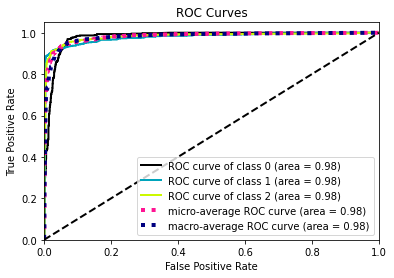

In [ ]:
svc_model = SentimentManager(TfidfVectorizer(ngram_range=(1,2)),
                              svm.SVC(C = 1,
                              kernel = "linear", probability = True))
X = svc_model.transform_comments_into_count_array(preprocessed_comments)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, sentiments, test_size = 0.2, random_state=None)
svc_model.train(X_train, y_train)

probabs = svc_model.predict_proba(X_test)
y_true = np.array(y_test)
y_probabs = copy.copy(probabs)
skplt.metrics.plot_roc_curve(y_true, y_probabs)
plt.show()

### Bag of Words

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


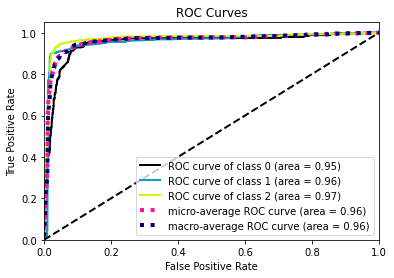

In [ ]:
svc_model = SentimentManager(CountVectorizer(ngram_range=(1,2)),
                              svm.SVC(C = 1,
                              kernel = "linear", probability = True))
X = svc_model.transform_comments_into_count_array(preprocessed_comments)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, sentiments, test_size = 0.2, random_state=None)
svc_model.train(X_train, y_train)
# calculate the fpr and tpr for all thresholds of the classification
probabs = svc_model.predict_proba(X_test)
y_true = np.array(y_test) # ground truth labels
y_probabs = copy.copy(probabs)# predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc_curve(y_true, y_probabs)
plt.show()

## Multinomial NB

### TF-IDF

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


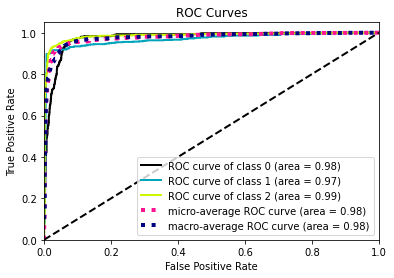

In [ ]:
multinomialNB_model = SentimentManager(TfidfVectorizer(ngram_range=(1,2)),
                              MultinomialNB(alpha = 0.1, fit_prior = False))
X = multinomialNB_model.transform_comments_into_count_array(preprocessed_comments)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, sentiments, test_size = 0.2, random_state=None)
multinomialNB_model.train(X_train, y_train)
# calculate the fpr and tpr for all thresholds of the classification
probabs = multinomialNB_model.predict_proba(X_test)
y_true = np.array(y_test) # ground truth labels
y_probabs = copy.copy(probabs)# predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc_curve(y_true, y_probabs)
plt.show()

### Bag of Words

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


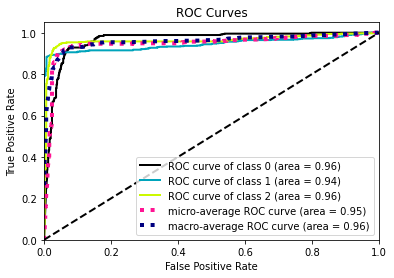

In [ ]:
multinomialNB_model = SentimentManager(CountVectorizer(ngram_range=(1,2)),
                              MultinomialNB(alpha = 1, fit_prior = True))
X = multinomialNB_model.transform_comments_into_count_array(preprocessed_comments)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, sentiments, test_size = 0.2, random_state=None)
multinomialNB_model.train(X_train, y_train)
# calculate the fpr and tpr for all thresholds of the classification
probabs = multinomialNB_model.predict_proba(X_test)
y_true = np.array(y_test) # ground truth labels
y_probabs = copy.copy(probabs)# predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc_curve(y_true, y_probabs)
plt.show()

## Passive Aggressive

### TF-IDF

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


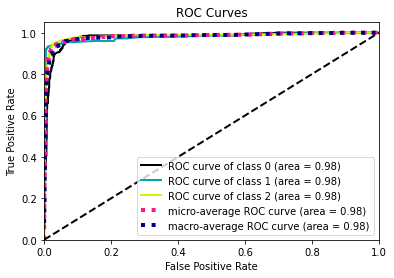

In [ ]:
passive_agressive_model = SentimentManager(TfidfVectorizer(ngram_range=(1,2)),
                                            PassiveAggressiveClassifier(C=0.03,
                                                loss="hinge", warm_start= True))
X = passive_agressive_model.transform_comments_into_count_array(preprocessed_comments)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, sentiments, test_size = 0.2, random_state=None)
passive_agressive_model.train(X_train, y_train)
# calculate the fpr and tpr for all thresholds of the classification
confidence_scores = passive_agressive_model.data_classification_model.decision_function(X_test)
y_true = np.array(y_test) # ground truth labels
y_probabs = copy.copy(confidence_scores)# predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc_curve(y_true, y_probabs)
plt.show()

### Bag of Words

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


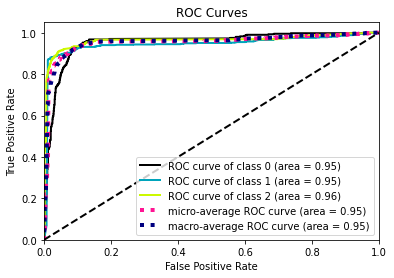

In [ ]:
passive_agressive_model = SentimentManager(CountVectorizer(ngram_range=(1,2)),
                                            PassiveAggressiveClassifier(C=0.003,
                                                loss="hinge", warm_start= True))
X = passive_agressive_model.transform_comments_into_count_array(preprocessed_comments)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, sentiments, test_size = 0.2, random_state=None)
passive_agressive_model.train(X_train, y_train)
# calculate the fpr and tpr for all thresholds of the classification
confidence_scores = passive_agressive_model.data_classification_model.decision_function(X_test)
y_true = np.array(y_test) # ground truth labels
y_probabs = copy.copy(confidence_scores)# predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc_curve(y_true, y_probabs)
plt.show()

In [ ]:
print(confidence_scores)

[[-1.02980910e+00  1.01267234e+00 -1.01808476e+00]
 [ 1.13996986e+01  2.10987357e-01 -1.55364222e+01]
 [-1.19830197e+00 -1.18784034e+00  1.07407442e+00]
 ...
 [-4.19224790e+00 -3.94222963e+00  5.53217443e+00]
 [-1.91918951e-03 -4.28509760e-01 -1.69128423e+00]
 [-1.86041909e+00 -1.02886989e+00  9.89825349e-01]]


In [ ]:
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_we